In [2]:
from finrl.finrl_meta.env_cryptocurrency_trading.env_multiple_crypto import CryptoEnv
from finrl.agents.elegantrl.models import DRLAgent as DRLAgent_erl
from finrl.finrl_meta.preprocessor.preprocessors import data_split
from finrl import config
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import datetime



/home/henry/miniconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
import ccxt
import pandas as pd
import numpy as np


In [3]:
import key


## CCXT

In [8]:
exchange = ccxt.binance()
exchange.apiKey = key.apiKey
exchange.secret = key.secret
assert exchange.check_required_credentials()


In [9]:
balances = exchange.fetch_balance()["info"]["balances"]


In [10]:
for balance in balances:
    if float(balance["free"]) > 0.0:
        print(balance["asset"], float(balance["free"]))


BTC 0.00375719
ETH 0.02356706
USDT 251.64291132
MATIC 0.08
DOGE 1.519


In [11]:
exchange.rateLimit


50

In [61]:
price = exchange.fetch_ohlcv("BTC/USDT", "30m", limit=1000)


In [64]:
price_df = pd.DataFrame(
    price, columns=["date", "open", "high", "low", "close", "volume"]
)
price_df["date"] = pd.to_datetime(price_df["date"], unit="ms")
price_df["tic"] = "BTC"


In [65]:
price_df.head()


,time,open,high,low,close,volume,tic
0,2022-04-01 18:30:00,46361.80,46399.94,46250.00,46334.63,533.20807,BTC
1,2022-04-01 19:00:00,46334.62,46394.64,46140.00,46185.52,645.29839,BTC
2,2022-04-01 19:30:00,46185.52,46378.39,46141.60,46361.68,715.83305,BTC
3,2022-04-01 20:00:00,46361.68,46380.16,46265.85,46294.59,373.98524,BTC
4,2022-04-01 20:30:00,46294.62,46370.00,46075.85,46145.38,515.18025,BTC


## Read Doneloaded Data

In [4]:
tic_list = [
    "BNBUSDT",
    "BTCUSDT",
    "ETHUSDT",
    "XRPUSDT",
    "SOLUSDT",
    "LUNAUSDT",
    "ADAUSDT",
    "AVAXUSDT",
    "DOGEUSDT",
    "DOTUSDT",
]

interval = "1h"


In [5]:
df_list = []
for tic in tic_list:
    data_path = f"./data/{tic}-{interval}.csv"
    data = pd.read_csv(data_path).values
    df = pd.DataFrame(
        data,
        columns=[
            "date",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "close_time",
            "quote_asset_volume",
            "number_of_trades",
            "taker_buy_base_asset_volume",
            "taker_buy_quote_asset_volume",
            "ignore",
        ],
    )
    df["date"] = pd.to_datetime(df["date"].add(1800000), unit="ms")
    df.drop(
        columns=[
            "close_time",
            "quote_asset_volume",
            "number_of_trades",
            "taker_buy_base_asset_volume",
            "taker_buy_quote_asset_volume",
            "ignore",
        ],
        inplace=True,
    )
    df["tic"] = tic
    df_list.append(df)

price_df = pd.concat(df_list)
price_df = price_df.sort_values(by=["date", "tic"], ignore_index=True)


In [6]:
from data_processor.indicator import add_tech_indicator, add_fundamental_data

data_df = add_tech_indicator(price_df).dropna(how='any')
data_df.iloc[0]['date']

Timestamp('2021-01-06 00:30:00')

In [7]:
train = data_split(data_df, "2021-06-01", "2022-1-31")
trade = data_split(data_df, "2022-02-01", "2022-3-31")
print(len(train), len(trade))

58500 13920


In [8]:
import data_processor.config

indicators = data_processor.config.TECH_INDICATORS
n_indicators = len(indicators)
n_indicators


8

In [9]:
stock_dimension = len(data_df.tic.unique())
stock_dimension

10

In [10]:
state_space = 1 + (2 + n_indicators) * stock_dimension
state_space

101

In [11]:
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent

env_kwargs = {
    "hmax": 1000,
    "initial_amount": 1000000,
    # "initial_list": [10000000] + [0 for i in range(stock_dimension)],
    # buy and sell cost for each stock
    "num_stock_shares": [0] * stock_dimension,
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": indicators,
    "action_space": stock_dimension,
    "reward_scaling": 1e-3,
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### SAC

In [13]:
agent = DRLAgent(env=env_train)
SAC_PARAMS = {
    "batch_size": 1024,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model(
    "sac", model_kwargs=SAC_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR
)

{'batch_size': 1024, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [14]:
trained_sac = agent.train_model(
    model=model_sac, tb_log_name="sac", total_timesteps=100000
)
model = trained_sac

Logging to tensorboard_log/sac_3
------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 49          |
|    time_elapsed    | 675         |
|    total_timesteps | 33548       |
| train/             |             |
|    actor_loss      | 4.84e+05    |
|    critic_loss     | 1.26e+09    |
|    ent_coef        | 2.65        |
|    ent_coef_loss   | -113        |
|    learning_rate   | 0.0001      |
|    n_updates       | 33447       |
|    reward          | 0.075381175 |
------------------------------------
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 49          |
|    time_elapsed    | 1361        |
|    total_timesteps | 67096       |
| train/             |             |
|    actor_loss      | 5.36e+05    |
|    critic_loss     | 2.62e+08    |
|    ent_coef        | 75.8        |
|    ent_coef_loss   | -504        |
|    

### DDPG

In [12]:
DDPG_PARAMS = {"batch_size": 256, "buffer_size": 100000, "learning_rate": 0.0001}

agent = DRLAgent(env=env_train)
model_ddpg = agent.get_model(
    "ddpg", model_kwargs=DDPG_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR
)


{'batch_size': 256, 'buffer_size': 100000, 'learning_rate': 0.0001}
Using cuda device


In [13]:
trained_ddpg = agent.train_model(
    model=model_ddpg, tb_log_name="ddpg", total_timesteps=50000
)


Logging to tensorboard_log/ddpg_3
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 113      |
|    time_elapsed    | 205      |
|    total_timesteps | 23400    |
| train/             |          |
|    actor_loss      | 4.69e+04 |
|    critic_loss     | 7.95e+07 |
|    learning_rate   | 0.0001   |
|    n_updates       | 17550    |
|    reward          | 9.983559 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 105      |
|    time_elapsed    | 445      |
|    total_timesteps | 46800    |
| train/             |          |
|    actor_loss      | 1.26e+04 |
|    critic_loss     | 1.39e+07 |
|    learning_rate   | 0.0001   |
|    n_updates       | 40950    |
|    reward          | 9.983559 |
---------------------------------
day: 5849, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 999001.00
to

In [14]:
model = trained_ddpg

### PPO

In [19]:
agent = DRLAgent(env=env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model(
    "ppo", model_kwargs=PPO_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR
)

trained_ppo = agent.train_model(
    model=model_ppo, tb_log_name="ppo", total_timesteps=100000
)

model = trained_ppo

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
Logging to tensorboard_log/ppo_1
-------------------------------------
| time/              |              |
|    fps             | 135          |
|    iterations      | 1            |
|    time_elapsed    | 15           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.014734214 |
-------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 137           |
|    iterations           | 2             |
|    time_elapsed         | 29            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.0074332575  |
|    clip_fraction        | 0.0609        |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | -0.194        

## TEST

In [15]:
e_trade_gym = StockTradingEnv(df=trade, **env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=model, environment=e_trade_gym
)

hit end!


In [16]:
df_actions.to_csv("action.csv")

In [17]:
df_account_value.tail()

,date,account_value
1387,2022-03-30 19:30:00,1.261306e+06
1388,2022-03-30 20:30:00,1.268097e+06
1389,2022-03-30 21:30:00,1.258686e+06
1390,2022-03-30 22:30:00,1.259270e+06
1391,2022-03-30 23:30:00,1.257847e+06


In [18]:
baseline_df = trade[trade['tic'] == "DOGEUSDT"]

In [19]:
test_ret = get_daily_return(df_account_value)
base_ret = get_daily_return(baseline_df, "close")

In [20]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.042404
Cumulative returns     0.257847
Annual volatility      0.133215
Sharpe ratio           0.378562
Calmar ratio           0.149690
Stability              0.010408
Max drawdown          -0.283278
Omega ratio            1.070970
Sortino ratio          0.542761
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014570
Daily value at risk   -0.016583
dtype: float64


Start date,2022-02-01
End date,2022-03-30
Total months,66
,Backtest
Annual return,4.24%
Cumulative returns,25.785%
Annual volatility,13.321%
Sharpe ratio,0.38
Calmar ratio,0.15
Stability,0.01
Max drawdown,-28.328%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.33,2022-02-09,2022-02-24,2022-03-27,33
1,7.81,2022-02-01,2022-02-03,2022-02-04,3
2,4.42,2022-02-08,2022-02-08,2022-02-09,2
3,3.42,2022-03-29,2022-03-30,NaT,NaN
4,2.58,2022-02-04,2022-02-04,2022-02-04,1


Stress Events,mean,min,max
New Normal,0.02%,-4.75%,5.35%


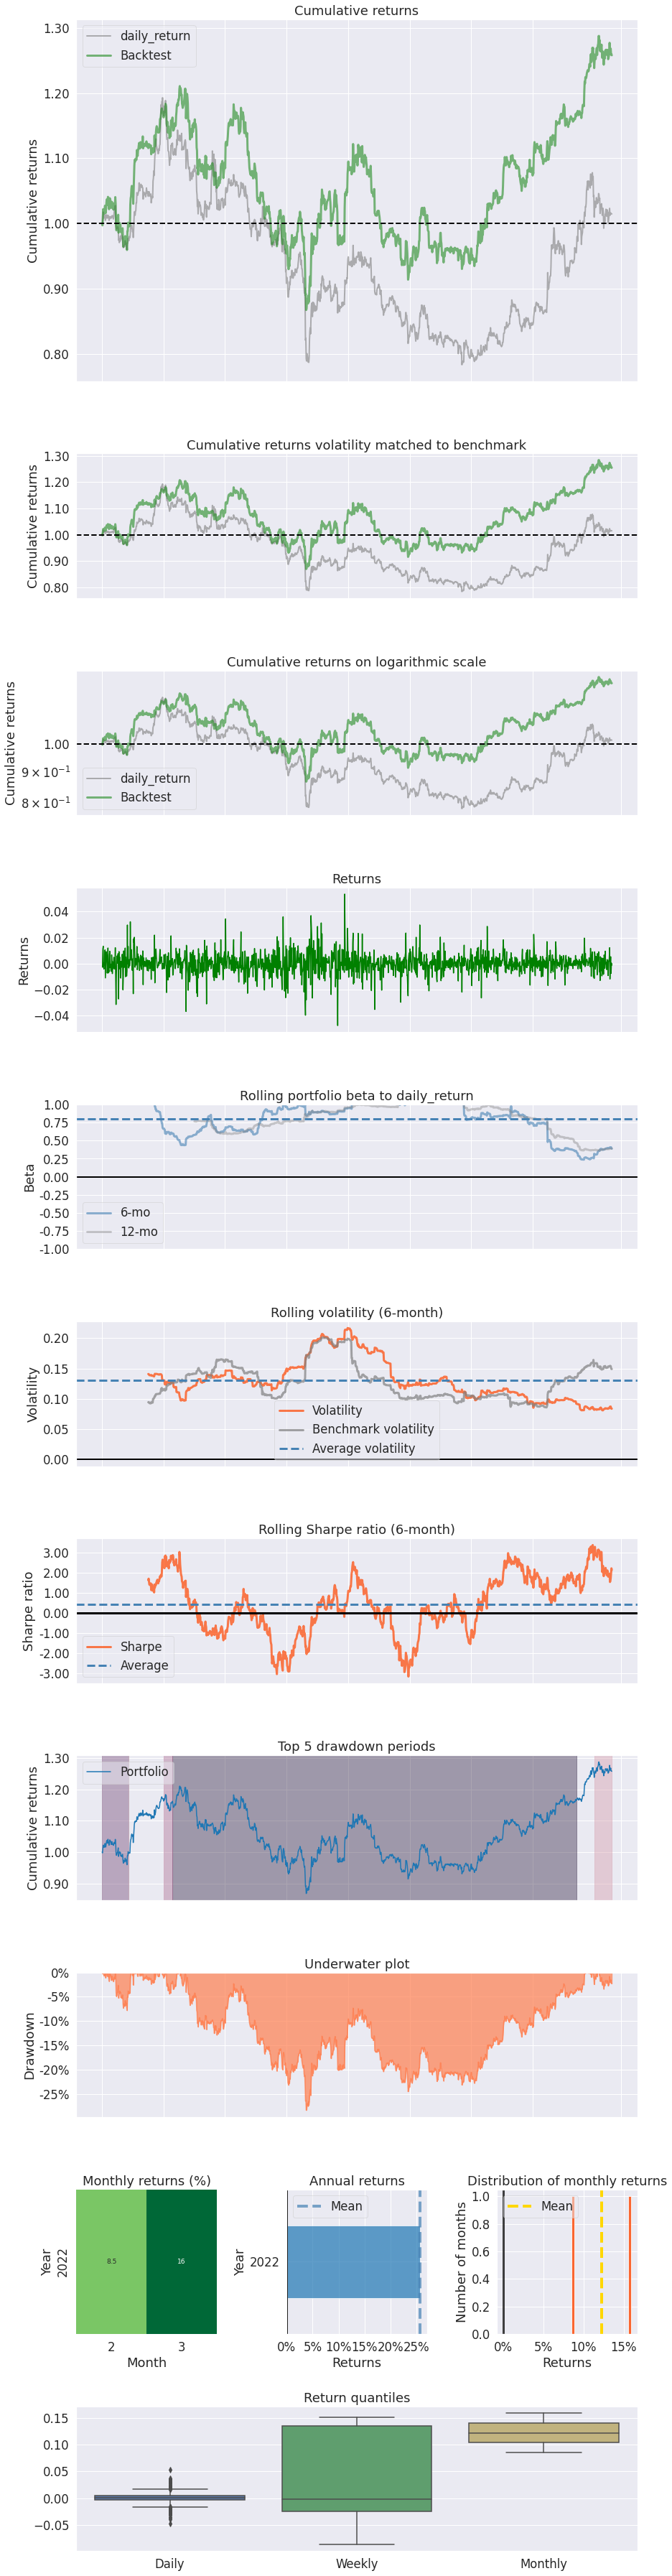

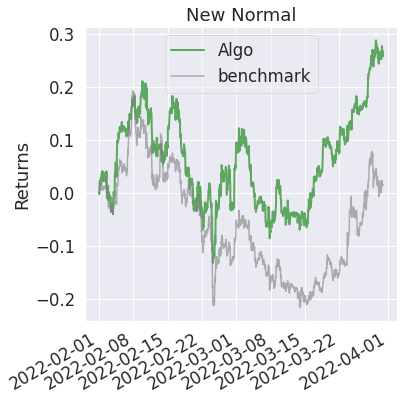

In [21]:
%matplotlib inline

import pyfolio
pyfolio.create_full_tear_sheet(returns=test_ret, benchmark_rets=base_ret)

## Fund

In [101]:
import yfinance as yf

treasury_bond = yf.download(tickers="^FVX ^TNX ^TYX", start="2021-01-01", end="2022-01-01")["Adj Close"]


[*********************100%***********************]  3 of 3 completed


In [102]:
treasury_bond = treasury_bond.resample(rule="30min").mean().ffill().reset_index().rename(
    columns={"Date": "date"}
)


In [103]:
treasury_bond.tail()

,date,^FVX,^TNX,^TYX
17516,2021-12-30 22:00:00,1.274,1.515,1.925
17517,2021-12-30 22:30:00,1.274,1.515,1.925
17518,2021-12-30 23:00:00,1.274,1.515,1.925
17519,2021-12-30 23:30:00,1.274,1.515,1.925
17520,2021-12-31 00:00:00,1.263,1.512,1.905


In [108]:
pd.merge(price_df, treasury_bond, how='left', on='date')

,date,open,high,low,close,volume,tic,^FVX,^TNX,^TYX
0,2021-01-01 01:00:00,0.178790,0.180770,0.178780,0.180510,5.359029e+06,ADAUSDT,0.361,0.917,1.646
1,2021-01-01 01:00:00,3.148500,3.260900,3.040500,3.246100,1.338404e+05,AVAXUSDT,0.361,0.917,1.646
2,2021-01-01 01:00:00,37.065300,37.442300,37.000000,37.376400,4.283987e+04,BNBUSDT,0.361,0.917,1.646
3,2021-01-01 01:00:00,28836.630000,29031.340000,28836.620000,28995.130000,9.911227e+02,BTCUSDT,0.361,0.917,1.646
4,2021-01-01 01:00:00,0.004639,0.004701,0.004634,0.004679,1.372140e+07,DOGEUSDT,0.361,0.917,1.646
...,...,...,...,...,...,...,...,...,...,...
174875,2022-01-01 00:00:00,26.760000,26.910000,26.620000,26.660000,8.193444e+04,DOTUSDT,NaN,NaN,NaN
174876,2022-01-01 00:00:00,3685.820000,3697.900000,3672.220000,3676.230000,3.729057e+03,ETHUSDT,NaN,NaN,NaN
174877,2022-01-01 00:00:00,85.860000,86.000000,85.300000,85.460000,3.366913e+04,LUNAUSDT,NaN,NaN,NaN
174878,2022-01-01 00:00:00,170.400000,171.380000,169.760000,169.990000,3.436818e+04,SOLUSDT,NaN,NaN,NaN
